# Stock Price Indicator
                
## Project aims to predict adjusted close price of some stocks chosen previously.


## 1- Data Exploration
### A- get historical values
### B- plot Adjusted Close column
### C- check for null values


In [1]:
#A- get historical values

import pandas as pd
import pandas_datareader as pdr
import datetime

adjclose = 'Adj Close'

stock_list = ['AAPL', 'AMZN', 'AVGO', 'CSCO', 'MA', 'MSFT', 'NVDA', 'NVS', 'PFE', 'QCOM', 'TXN', 'V', 'WMT']

start=datetime.datetime(2010,3,20)

end=datetime.datetime(2019,3,19)

#for stock in stock_list:
    #history = pdr.get_data_yahoo(stock, start, end)
    #history.to_csv('./data1/'+stock+'.csv')

AMZN = pd.read_csv('data/AMZN.csv', header=0, parse_dates=['Date'])
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-03-22,130.960007,128.639999,130.199997,130.470001,5383400,130.470001
1,2010-03-23,130.940002,128.070007,130.889999,129.259995,4213100,129.259995
2,2010-03-24,129.399994,127.199997,128.639999,128.039993,4696400,128.039993
3,2010-03-25,136.910004,128.039993,129.139999,134.729996,16209600,134.729996
4,2010-03-26,136.990005,133.759995,134.899994,135.059998,6565700,135.059998


In [2]:
# B- plot Adjusted Close column

import datetime
import matplotlib as plt

stock_data_list = []

for stock in stock_list:
    stock_data = pd.read_csv('data/'+stock+'.csv', header=0, parse_dates=['Date'])
    stock_data.set_index('Date',inplace=True)
    plott = stock_data[adjclose].plot(figsize=(16, 12), label=stock)
    plott.legend()
    stock_data['stock_name'] = stock
    stock_data_list.append(stock_data)



In [3]:
# C- check for null values

for stock_data in stock_data_list:
    print(stock_data.isnull().any().any())

False
False
False
False
False
False
False
False
False
False
False
False
False


## 2- Domain Research
### A- Add Key Feature Columns to Data
### B- Plot Examples for Key Features

In [4]:
#A- Add Key Feature Columns to Data
import numpy as np
#Add MACD 26, 12 day periods
def add_MACD(dataframe):
    macd26 = dataframe[adjclose].ewm(span=26, min_periods=26, adjust= True).mean()
    macd12 = dataframe[adjclose].ewm(span=12, min_periods=12, adjust= True).mean()
    dataframe["MACD"] = macd26-macd12
    return dataframe

#Add RSI Wilder's RSI
def add_RSI(df, column=adjclose, period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    return df.join(rsi.to_frame('RSI'))

#Add Bollinger Bands
def add_BollingerBand(df, column=adjclose, period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

def get_weighted_average(dataframe,window,columnname_data,columnname_weights):
    processed_dataframe=dataframe.loc[:,(columnname_data,columnname_weights)].set_index(columnname_weights)   
    def get_mean_withweights(processed_dataframe_windowed):
        return np.average(a=processed_dataframe_windowed,weights=processed_dataframe_windowed.index)
    tmp_df = processed_dataframe.rolling(window=window).apply(func=get_mean_withweights,raw=False)
    tmp_df = tmp_df.reset_index()
    dataframe = dataframe.reset_index()
    tmp_df2 = dataframe.join(tmp_df[adjclose].to_frame('WMA'))
    tmp_df2.set_index('Date',inplace=True)
    #print(tmp_df2)
    return tmp_df2


for index, stock_data in enumerate(stock_data_list):
    stock_data = add_MACD(stock_data)
    stock_data = add_RSI(stock_data)
    stock_data = add_BollingerBand(stock_data)
    stock_data = get_weighted_average(stock_data,10,adjclose, 'Volume')
    #print(stock_data.columns)
    #print(stock_data)
    #stock_data['MACD'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['RSI'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDUP'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDLO'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['WMA'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    stock_data = stock_data[25:] #delete NaN values
    stock_data_list[index] = stock_data

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'stock_name',
       'MACD', 'RSI', 'BBANDUP', 'BBANDLO', 'WMA'],
      dtype='object')


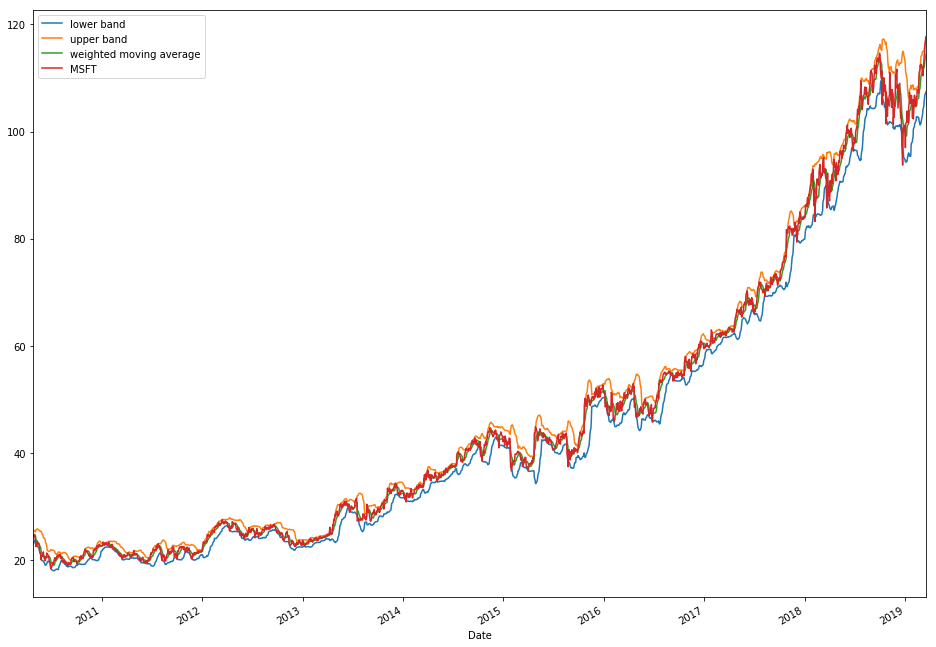

In [5]:
def plot_stock(index):
    stock_data = stock_data_list[index]
    print(stock_data.columns)

    #plot Bollinger Bands
    plt1 = stock_data['BBANDLO'].plot(figsize=(16, 12), label='lower band')
    stock_data['BBANDUP'].plot(label='upper band')
    stock_data['WMA'].plot(label='weighted moving average')
    stock_data[adjclose].plot(label=stock_data['stock_name'][0])
    plt1.legend()
    
plot_stock(5)



#plot RSI and MACD
#plot2 =  stock_data['RSI'].plot(figsize=(16, 12), label='RSI')

## 2- Data Normalization & Seperation

In [6]:
from sklearn import preprocessing

normalized_stock_list = []
y_adj_close_list = []
scaler = preprocessing.MinMaxScaler()


for stock_data in stock_data_list:
    stock_data = stock_data.drop(columns='stock_name')
    y_adj_close_list.append(stock_data[adjclose])
    stock_data = stock_data.drop(columns=adjclose)
    names = stock_data.columns
    scaled_df = scaler.fit_transform(stock_data)
    scaled_df = pd.DataFrame(scaled_df, columns=names)
    normalized_stock_list.append(scaled_df)

#since we want n+1 adj close price to be predicted with the n th day values
#we need to shift y values for 1 day 
for y_adj_close in y_adj_close_list:
    y_adj_close.shift(-1)




    
print(y_adj_close_list[5]) # our target list to predict  
print(normalized_stock_list[5]) # our input values for models  
   


Date
2010-04-27     24.651001
2010-04-28     24.698944
2010-04-29     24.770861
2010-04-30     24.403294
2010-05-03     24.658993
2010-05-04     24.075682
2010-05-05     23.851942
2010-05-06     23.156761
2010-05-07     22.541483
2010-05-10     23.124798
2010-05-11     23.076849
2010-05-12     23.524330
2010-05-13     23.364517
2010-05-14     23.116808
2010-05-17     23.124798
2010-05-18     22.956236
2010-05-19     22.667269
2010-05-20     21.760265
2010-05-21     21.543539
2010-05-24     21.086029
2010-05-25     20.925493
2010-05-26     20.074663
2010-05-27     20.869303
2010-05-28     20.708771
2010-06-01     20.781010
2010-06-02     21.238535
2010-06-03     21.559595
2010-06-04     20.700745
2010-06-07     20.299412
2010-06-08     20.154936
                 ...    
2019-02-05    106.764046
2019-02-06    105.579102
2019-02-07    104.822327
2019-02-08    105.220634
2019-02-11    104.802422
2019-02-12    106.435448
2019-02-13    106.355782
2019-02-14    106.445404
2019-02-15    107.75

/home/omer/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3- Building:
### A: Benchmark Model
### B: RMSE and R2 Validation
### C: Solution Model
### D: Test Flow


In [7]:
# A- For Benchmark we will use standard linear regression
from keras.layers import Dense
from keras.models import Model, Sequential
from keras import initializers, optimizers
from sklearn.model_selection import train_test_split

from pylab import *


def create_benchmark_model():
   model = Sequential()
   model.add(Dense(1, activation = 'linear', input_dim = 10))
   sgd = optimizers.SGD(lr=0.2)
   model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['accuracy'])
   return model

# B - RMSE Score, R2 Score
from sklearn.metrics import mean_squared_error, r2_score


def RMSE_score(y, y_predicted, method_name):
    RMSE_score = np.sqrt(mean_squared_error(y, y_predicted))
    print(method_name + " RMSE Score: {0}".format(RMSE_score))
    return RMSE_score


def R2_score(y, y_predicted, method_name):
    R2_score = r2_score(y, y_predicted)
    print( method_name +" R2 Score: {0}".format(R2_score))
    return R2_score

def check_score(y, y_predicted, method_name):
    RMSE_score(y, y_predicted, method_name)
    R2_score(y, y_predicted, method_name)


Using TensorFlow backend.


In [8]:
# C - Solution Models LSTM and SVM 
from sklearn import svm
from keras.layers.recurrent import LSTM
from keras.layers import Dropout, Activation, Flatten
import numpy 

def create_svm_model():
    #model = svm.SVR(kernel='linear', C=100)
    model = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
    return model

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(return_sequences=True, input_shape=(1, 10), units=100, dropout=0.2))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model
       

In [9]:
#D -Test Flow

#create models
#linear_regression_model = create_benchmark_model()
#svm_model = create_svm_model()
lstm_model = create_lstm_model()


#split data
X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[0], y_adj_close_list[0], test_size=0.20, random_state=42)

#linear_regression_model.fit(X_train, y_train, epochs =400,batch_size = 32)
#linear_y_predict = linear_regression_model.predict(X_test)

#svm_model.fit(X_train, y_train)
#svm_y_predict = svm_model.predict(X_test)

trainX = numpy.reshape(X_train, (1, X_train.shape[0], -1))
testX = numpy.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

lstm_model.fit(trainX, y_train, batch_size =32,epochs = 10)
lstm_y_predict = lstm_model.predict(testX)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


ValueError: Must pass 2-d input

In [ ]:
#check score
#check_score(y_test, linear_y_predict, "Linear Regression")
#check_score(y_test, svm_y_predict, "SVM Model")
check_score(y_test, lstm_y_predict, "LSTM Model")

In [10]:
import numpy
#X_train.shape
trainX = numpy.reshape(X_train, (1, X_train.shape[0], -1))
#testX = numpy.reshape(X_test, (X_test.shape[0], 1, X_test.shape[0]))


X_train.head()




ValueError: Must pass 2-d input